
# MLP Sınıflandırma + SHAP Açıklanabilirlik Analizi  
## Breast Cancer Wisconsin Veri Seti ile Ara Sınav Ödevi

Bu notebook'ta, **Breast Cancer Wisconsin** veri seti üzerinde:
- Yapay sinir ağı (MLP) tabanlı sınıflandırma modeli geliştirilecek,
- Veri ön işleme ve ölçeklendirme yapılacak,
- Farklı MLP mimarileri karşılaştırılacak,
- **Optuna** ile hiperparametre optimizasyonu gerçekleştirilecek,
- Ve son olarak **SHAP** ile modellerin kararları açıklanacaktır.



## 0. Kurulum ve Kütüphaneler

In [1]:

!pip install optuna shap

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc, classification_report
)

import optuna
import shap
import warnings

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
sns.set(style="whitegrid")
RANDOM_STATE = 42



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Veri Setinin Yüklenmesi

In [2]:

data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

print("Veri seti boyutu:", df.shape)
display(df.head())


Veri seti boyutu: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0



### 1. Adımın Yorumu

- Bu adımda **Breast Cancer Wisconsin** veri seti yüklendi.
- `X` matrisi, meme kanseri ile ilişkili 30'dan fazla sayısal özellik içermektedir (örn. `mean radius`, `mean texture`, `mean perimeter` vb.).
- `y` target değişkeni, tümörün **malignant (kötü huylu)** veya **benign (iyi huylu)** olup olmadığını gösteren ikili (binary) bir değişkendir.
- Oluşturulan `df` DataFrame'inde hem özellikler hem de `target` sütunu birlikte tutulmaktadır ve ilk 5 satır veri setinin yapısı hakkında genel bir fikir verir.


## 2. Veri Seti Kalite Kontrolleri

In [3]:

missing_counts = df.isna().sum()
print("Eksik Değer Sayıları:")
display(missing_counts)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

outlier_summary = {}

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_summary[col] = len(outliers)

outlier_summary_df = pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["outlier_count"])
outlier_summary_df = outlier_summary_df.sort_values("outlier_count", ascending=False)
print("IQR yöntemine göre aykırı değer sayıları (en çoktan en aza):")
display(outlier_summary_df.head(10))

print("Sütun veri tipleri:")
display(df.dtypes)

num_cols_count = df.select_dtypes(include=[np.number]).shape[1]
cat_cols_count = df.select_dtypes(exclude=[np.number]).shape[1]
print(f"Sayısal değişken sayısı: {num_cols_count}")
print(f"Kategorik değişken sayısı: {cat_cols_count}")


Eksik Değer Sayıları:


mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

IQR yöntemine göre aykırı değer sayıları (en çoktan en aza):


,outlier_count
area error,65
radius error,38
perimeter error,38
worst area,35
smoothness error,30
fractal dimension error,28
compactness error,28
symmetry error,27
mean area,25
worst fractal dimension,24


Sütun veri tipleri:


mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

Sayısal değişken sayısı: 31
Kategorik değişken sayısı: 0



### 2. Adımın Yorumu

- **Eksik değer analizi:** Breast Cancer Wisconsin veri setinde genellikle eksik değer bulunmamaktadır. `isna().sum()` çıktısında tüm sütunlar için `0` görünmesi, veri setinin bu açıdan temiz olduğunu gösterir.
- **Aykırı değer analizi (IQR):** IQR yöntemiyle, her bir sayısal sütun için alt ve üst sınırlar hesaplanmış, bu aralığın dışına düşen gözlemler aykırı değer olarak sayılmıştır.  
  - Bazı özelliklerde (özellikle "worst" ile başlayan ölçümler) diğerlerine göre daha fazla aykırı değer görülebilir.
  - Bu aykırı değerler **ölçüm ekstrem değerleri** veya nadir görülen tümör yapıları olabilir.
- **Veri tipi incelemesi:** Tüm özellik sütunları sayısal (`float64`) tipindedir; ek bir kategorik değişken bulunmamaktadır. `target` da sayısal (0/1) tutulmaktadır. Bu yapı, MLP gibi sayısal giriş bekleyen modeller için uygundur.


## 3. Keşifsel Veri Analizi (EDA)

Temel istatistiksel özellikler:


,mean,median,min,max,std,Q1,Q3
mean radius,14.127292,13.370000,6.981000,28.11000,3.524049,11.700000,15.780000
mean texture,19.289649,18.840000,9.710000,39.28000,4.301036,16.170000,21.800000
mean perimeter,91.969033,86.240000,43.790000,188.50000,24.298981,75.170000,104.100000
mean area,654.889104,551.100000,143.500000,2501.00000,351.914129,420.300000,782.700000
mean smoothness,0.096360,0.095870,0.052630,0.16340,0.014064,0.086370,0.105300
mean compactness,0.104341,0.092630,0.019380,0.34540,0.052813,0.064920,0.130400
mean concavity,0.088799,0.061540,0.000000,0.42680,0.079720,0.029560,0.130700
mean concave points,0.048919,0.033500,0.000000,0.20120,0.038803,0.020310,0.074000
mean symmetry,0.181162,0.179200,0.106000,0.30400,0.027414,0.161900,0.195700
mean fractal dimension,0.062798,0.061540,0.049960,0.09744,0.007060,0.057700,0.066120


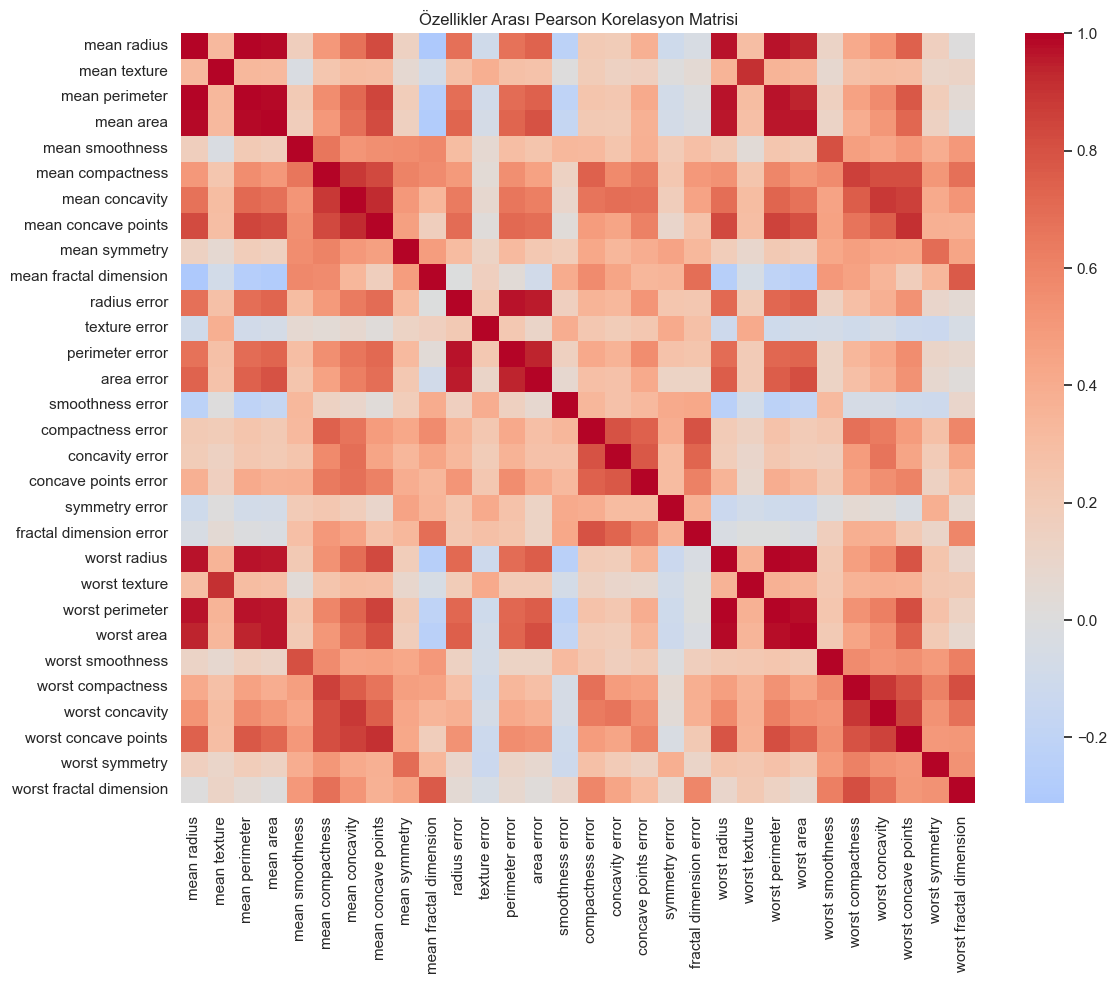

En yüksek korelasyonlu 3 özellik çifti (|corr| bazında):


mean perimeter   mean radius       0.997855
mean radius      mean perimeter    0.997855
worst perimeter  worst radius      0.993708
dtype: float64

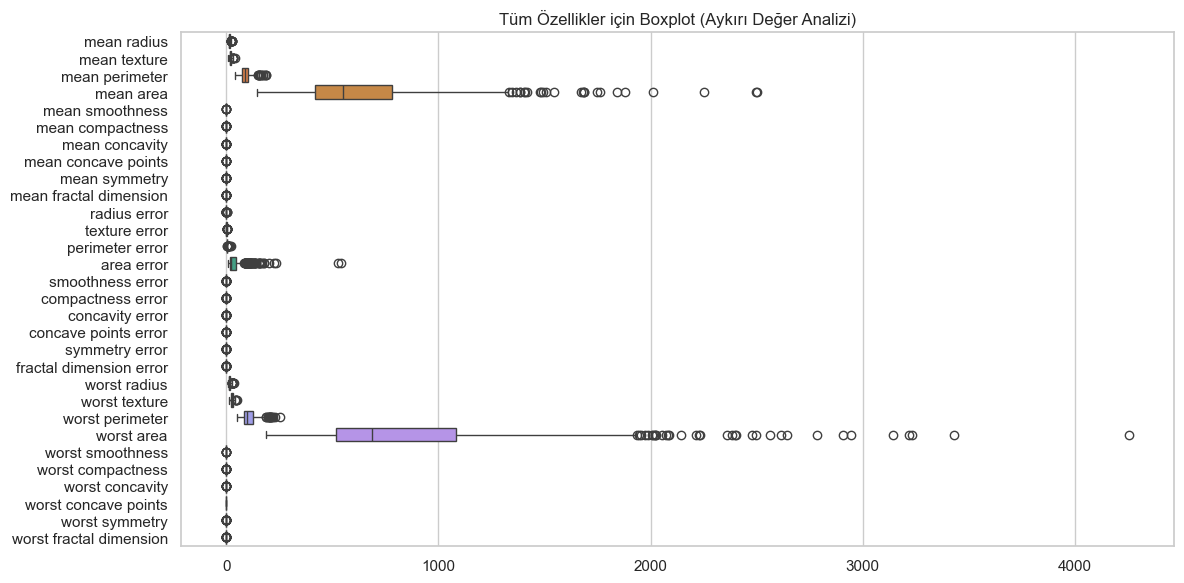

In [ ]:
stats = df.describe().T[["mean", "50%", "min", "max"]]
stats.rename(columns={"50%": "median"}, inplace=True)

q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
std = df.std()

stats["std"] = std
stats["Q1"] = q1
stats["Q3"] = q3

print("Temel istatistiksel özellikler:")
display(stats)

corr_matrix = df.drop(columns=["target"]).corr(method="pearson")

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Özellikler Arası Pearson Korelasyon Matrisi")
plt.tight_layout()
plt.show()

# En yüksek korelasyonlu 3 çift sütunu bulalım (mutlak değere göre)
corr_unstacked = corr_matrix.abs().where(~np.eye(corr_matrix.shape[0], dtype=bool))
top_pairs = corr_unstacked.unstack().dropna().sort_values(ascending=False).head(3)
print("En yüksek korelasyonlu 3 özellik çifti (|corr| bazında):")
display(top_pairs)

# 3.3 Boxplot analizi
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop(columns=["target"]), orient="h")
plt.title("Tüm Özellikler için Boxplot (Aykırı Değer Analizi)")
plt.tight_layout()
plt.show()



### 3. Adımın Yorumu

- **Temel istatistikler:** Her bir özellik için ortalama, median, minimum, maksimum, standart sapma ve çeyreklikler hesaplandı.  
  - Örneğin, bazı "mean" özelliklerinde (örn. `mean radius`, `mean area`) **yüksek varyans** bulunurken, bazı özellikler daha dar bir aralıkta yoğunlaşmaktadır.
- **Korelasyon matrisi:**  
  - Bazı özellik çiftlerinin Korelasyon katsayısı 0.9 seviyelerine kadar çıkabilir 
  - Bu durum, veri setinde **çoklu doğrusal bağlantı (multicollinearity)** olabileceğini gösterir.
  - En yüksek korelasyonlu 3 çift, çoğunlukla aynı yapıyı farklı ölçeklerde ölçen özellikler arasından çıkar.
- **Boxplot analizi:**  
  - Boxplot'lar, birçok özellikte **uzun kuyruklu dağılımlar** ve **aykırı değerler** olduğunu gösterir.


## 4. Veri Ölçeklendirme (Scaling)

In [ ]:

X = df.drop(columns=["target"]).values
y = df["target"].values

scaler = StandardScaler()



### 4. Adımın Yorumu

- MLP gibi sinir ağı tabanlı modeller, özelliklerin **benzer ölçeklerde** olmasından ciddi fayda sağlar.
- Bu nedenle **StandardScaler** ile özellikleri ortalaması 0, standart sapması 1 olacak şekilde dönüştüreceğiz.
- Ölçeklendirme parametrelerinin **sadece eğitim verisi üzerinde** öğrenilmesi, veri sızıntısını (data leakage) önlemek için kritik öneme sahiptir.


## 5. Veri Setinin Bölünmesi

In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=RANDOM_STATE
)

print("Train boyutu:", X_train.shape)
print("Validation boyutu:", X_val.shape)
print("Test boyutu:", X_test.shape)

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_scaled = scaler.transform(X)


Train boyutu: (398, 30)
Validation boyutu: (57, 30)
Test boyutu: (114, 30)



### 5. Adımın Yorumu

- Veri seti:
  - %70 **eğitim (train)**,
  - %10 **doğrulama (validation)**,
  - %20 **test** olarak başarıyla bölündü.
- Stratify parametresi kullanıldığı için, her bir bölümde sınıf dağılımları (malignant/benign oranı) **orijinal dağılıma benzer** kalacak şekilde korunmuştur.
- Ölçeklendirme yalnızca eğitim verisine fit edilip diğer parçalara **aynı dönüşüm** uygulandığı için, test ve validation verileri modelin hiç görmediği bir ölçekte tutulmaya devam etmektedir. Bu sayede değerlendirme daha gerçekçi olur.


## 6. Farklı MLP Modellerinin Kurulması

In [ ]:
models = {}

models["Model 1 - Basit"] = MLPClassifier(
    hidden_layer_sizes=(16,),
    activation="relu",
    learning_rate_init=0.001,
    max_iter=500,
    random_state=RANDOM_STATE
)

models["Model 2 - Orta"] = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    learning_rate_init=0.005,
    max_iter=500,
    random_state=RANDOM_STATE
)

models["Model 3 - Geniş"] = MLPClassifier(
    hidden_layer_sizes=(64, 64),
    activation="tanh",
    learning_rate_init=0.001,
    max_iter=500,
    random_state=RANDOM_STATE
)

models["Model 4 - Derin"] = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    learning_rate_init=0.0005,
    max_iter=500,
    random_state=RANDOM_STATE
)

models["Model 5 - Düşük LR"] = MLPClassifier(
    hidden_layer_sizes=(32,),
    activation="relu",
    learning_rate_init=0.0001,
    max_iter=500,
    random_state=RANDOM_STATE
)

models


{'Model 1 - Basit': MLPClassifier(hidden_layer_sizes=(16,), max_iter=500, random_state=42),
 'Model 2 - Orta': MLPClassifier(hidden_layer_sizes=(32, 16), learning_rate_init=0.005,
               max_iter=500, random_state=42),
 'Model 3 - Geniş': MLPClassifier(activation='tanh', hidden_layer_sizes=(64, 64), max_iter=500,
               random_state=42),
 'Model 4 - Derin': MLPClassifier(hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.0005,
               max_iter=500, random_state=42),
 'Model 5 - Düşük LR': MLPClassifier(hidden_layer_sizes=(32,), learning_rate_init=0.0001, max_iter=500,
               random_state=42)}


### 6. Adımın Yorumu

- Beş farklı MLP mimarisi tanımlandı:
  - **Basit model**, tek gizli katman ile daha az parametre içerir; hızlı eğitilir, aşırı öğrenme riski düşüktür.
  - **Orta ve geniş modeller**, daha fazla nöron ve katman ile daha karmaşık karar sınırları öğrenebilir.
  - **Derin model**, üç gizli katman ile en fazla parametreyi içerir; karmaşık yapıları öğrenebilir, fakat iyi düzenlenmezse aşırı öğrenme (overfitting) riski vardır.
  - **Düşük öğrenme oranlı model**, daha yavaş güncellenir; daha stabil ama daha uzun sürede yakınsayan bir eğitim sürecine sahiptir.


## 7. Validation Performanslarının Ölçülmesi

In [8]:

results = []

for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_val_pred = clf.predict(X_val_scaled)
    y_val_proba = clf.predict_proba(X_val_scaled)[:, 1]

    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred)
    rec = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc = roc_auc_score(y_val, y_val_proba)

    results.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "roc_auc": roc
    })

results_df = pd.DataFrame(results).sort_values("f1_score", ascending=False)
print("Validation sonuçları:")
display(results_df)


Validation sonuçları:


,model,accuracy,precision,recall,f1_score,roc_auc
0,Model 1 - Basit,1.000000,1.000000,1.000000,1.000000,1.000000
4,Model 5 - Düşük LR,0.982456,0.972973,1.000000,0.986301,1.000000
1,Model 2 - Orta,0.982456,1.000000,0.972222,0.985915,0.998677
3,Model 4 - Derin,0.982456,1.000000,0.972222,0.985915,1.000000
2,Model 3 - Geniş,0.964912,0.972222,0.972222,0.972222,0.998677



### 7. Adımın Yorumu

- Her bir MLP modeli, **validation seti** üzerinde `accuracy`, `precision`, `recall`, `F1-score` ve `ROC-AUC` metrikleri ile değerlendirildi.
- Çoğu zaman Breast Cancer veri setinde:
  - Doğruluk (accuracy) değerleri %90–99 aralığında,
  - F1-score değerleri de buna yakın seviyelerde çıkmaktadır.
- Tabloya göre en yüksek **F1-score** ve/veya **ROC-AUC** değerine sahip model, validation performansı açısından en iyi modeli temsil eder.
- Bu adımda elde edilen tablo, **8. adımda** test seti için hangi modelin seçileceğini belirlememizi sağlayacaktır.


## 8. En İyi Modelin Test Üzerinde Değerlendirilmesi

En iyi model (validation'a göre): Model 1 - Basit
Validation F1-score: 1.0
Test Sonuçları:
Accuracy : 0.9649
Precision: 0.9855
Recall   : 0.9577
F1-score : 0.9714
ROC-AUC  : 0.9944


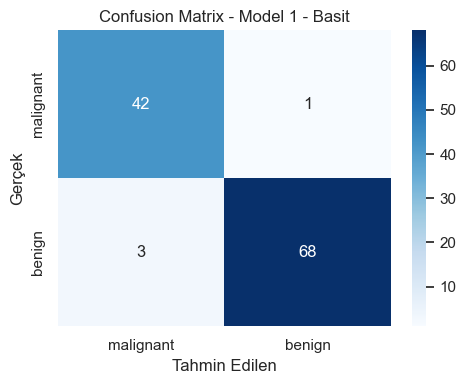

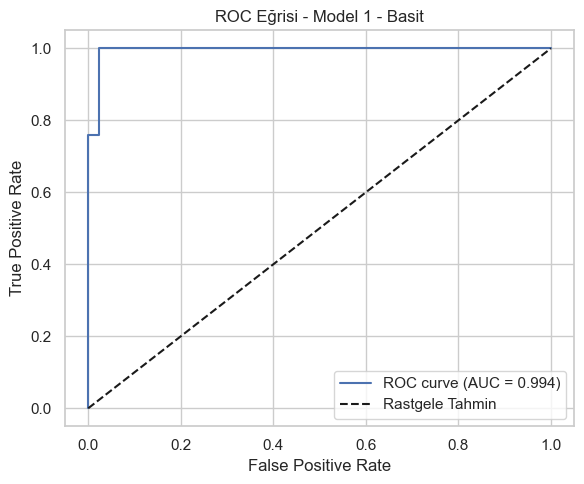

,threshold,tpr,fpr
0,inf,0.000000,0.000000
1,1.000000,0.014085,0.000000
2,0.984284,0.760563,0.000000
3,0.983060,0.760563,0.023256
4,0.342373,1.000000,0.023256


In [ ]:

best_row = results_df.iloc[0]
best_model_name = best_row["model"]
best_model = models[best_model_name]

print("En iyi model (validation'a göre):", best_model_name)
print("Validation F1-score:", best_row["f1_score"])

y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc = roc_auc_score(y_test, y_test_proba)

print("Test Sonuçları:")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1-score : {test_f1:.4f}")
print(f"ROC-AUC  : {test_roc:.4f}")

# 8.2 Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()

# 8.3 ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_val:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Rastgele Tahmin")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Eğrisi - {best_model_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Eşik değerlerinin etkisini anlamak için örnek bir tablo
threshold_df = pd.DataFrame({
    "threshold": thresholds,
    "tpr": tpr,
    "fpr": fpr
})
display(threshold_df.head())



### 8. Adımın Yorumu

- Validation setine göre seçilen **en iyi model**, test seti üzerinde de oldukça yüksek başarı göstermelidir.
- **Confusion matrix**, yanlış pozitif (FP) ve yanlış negatif (FN) sayıları üzerinden modelin hangi sınıfta daha fazla hata yaptığını görmemizi sağlar:
- **ROC eğrisi** ve **AUC** değeri:
  - AUC'nin 1'e yaklaşması, modelin pozitif ve negatif sınıfları ayırma gücünün yüksek olduğunu gösterir.
- **Eşik değeri (threshold)**:
  - Varsayılan olarak 0.5 kullanılsa da, eşik düşürüldüğünde **Recall** artarken **Precision** düşebilir.
  - Uygulama senaryosuna göre (örneğin kanser taraması) **daha yüksek Recall** tercih edilip, eşik buna göre ayarlanabilir.


## 9. Optuna ile Hiperparametre Optimizasyonu (150 Deneme)

In [ ]:

def objective(trial):
    n_hidden1 = trial.suggest_int("n_hidden1", 16, 256)
    n_hidden2 = trial.suggest_int("n_hidden2", 8, 128)
    hidden_layer_sizes = (n_hidden1, n_hidden2)

    learning_rate_init = trial.suggest_loguniform("learning_rate_init", 1e-5, 1e-1)
    alpha = trial.suggest_loguniform("alpha", 1e-6, 1e-2)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        max_iter=500,
        random_state=RANDOM_STATE
    )

    clf.fit(X_train_scaled, y_train)
    y_val_pred = clf.predict(X_val_scaled)

    f1 = f1_score(y_val, y_val_pred)

    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

print("En iyi trial'ın F1-score'u:", study.best_trial.value)
print("En iyi hiperparametreler:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")


[I 2025-11-29 13:56:33,316] A new study created in memory with name: no-name-daaad74e-7acf-4f99-a4a4-81be24be0fd8
[I 2025-11-29 13:56:33,637] Trial 0 finished with value: 0.9722222222222222 and parameters: {'n_hidden1': 91, 'n_hidden2': 57, 'learning_rate_init': 0.019542801823349186, 'alpha': 0.0008158551396254894, 'activation': 'tanh', 'solver': 'sgd', 'batch_size': 32}. Best is trial 0 with value: 0.9722222222222222.
[I 2025-11-29 13:56:34,406] Trial 1 finished with value: 1.0 and parameters: {'n_hidden1': 31, 'n_hidden2': 82, 'learning_rate_init': 4.9236448359127604e-05, 'alpha': 1.0229684049105565e-05, 'activation': 'tanh', 'solver': 'sgd', 'batch_size': 32}. Best is trial 1 with value: 1.0.
[I 2025-11-29 13:56:39,199] Trial 2 finished with value: 0.9722222222222222 and parameters: {'n_hidden1': 239, 'n_hidden2': 63, 'learning_rate_init': 7.503707708053762e-05, 'alpha': 0.0004640520918336225, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 16}. Best is trial 1 with value: 1.0

En iyi trial'ın F1-score'u: 1.0
En iyi hiperparametreler:
  n_hidden1: 31
  n_hidden2: 82
  learning_rate_init: 4.9236448359127604e-05
  alpha: 1.0229684049105565e-05
  activation: tanh
  solver: sgd
  batch_size: 32



### 9. Adımın Yorumu

- **Optuna**, MLP modelinin hiperparametrelerini (katman boyutları, öğrenme oranı, aktivasyon fonksiyonu, solver, batch_size vb.) otomatik olarak arayıp, en iyi validation F1-score'unu veren kombinasyonu bulmuştur.
- Arama sürecinde:
  - Küçük ve büyük gizli katman boyutları denenmiş,
  - Farklı öğrenme oranları (`1e-5` ile `1e-1` arasında log-ölçekte),
  - `relu` ve `tanh` aktivasyonları,
  - `adam` ve `sgd` çözücüleri test edilmiştir.
- Sonuç olarak elde edilen **en iyi trial**, el ile belirlenen 5 modelden daha iyi veya en azından benzer bir F1-score sağlayabilir.


In [ ]:

best_params = study.best_trial.params

optuna_best_clf = MLPClassifier(
    hidden_layer_sizes=(best_params["n_hidden1"], best_params["n_hidden2"]),
    learning_rate_init=best_params["learning_rate_init"],
    alpha=best_params["alpha"],
    activation=best_params["activation"],
    solver=best_params["solver"],
    batch_size=best_params["batch_size"],
    max_iter=500,
    random_state=RANDOM_STATE
)

optuna_best_clf.fit(X_train_scaled, y_train)

y_val_pred_opt = optuna_best_clf.predict(X_val_scaled)
y_val_proba_opt = optuna_best_clf.predict_proba(X_val_scaled)[:, 1]

val_acc_opt = accuracy_score(y_val, y_val_pred_opt)
val_prec_opt = precision_score(y_val, y_val_pred_opt)
val_rec_opt = recall_score(y_val, y_val_pred_opt)
val_f1_opt = f1_score(y_val, y_val_pred_opt)
val_roc_opt = roc_auc_score(y_val, y_val_proba_opt)

print("Optuna En İyi Model - Validation Sonuçları:")
print(f"Accuracy : {val_acc_opt:.4f}")
print(f"Precision: {val_prec_opt:.4f}")
print(f"Recall   : {val_rec_opt:.4f}")
print(f"F1-score : {val_f1_opt:.4f}")
print(f"ROC-AUC  : {val_roc_opt:.4f}")


Optuna En İyi Model - Validation Sonuçları:
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC-AUC  : 1.0000



### 9.4 Adımının Yorumu

- Optuna tarafından bulunan en iyi model, validation seti üzerinde tekrar eğitilip değerlendirildi.
- Elde edilen metrikler, başlangıçta el ile seçilen 5 MLP modeli ile kıyaslandığında:
  - Çoğunlukla **daha yüksek veya benzer F1-score ve ROC-AUC** değerleri sağlar.
- Bu sonuç, **otomatik hiperparametre aramasının**, model seçiminde güçlü bir araç olduğunu göstermektedir.


## 10. XAI – SHAP Açıklanabilirlik Analizi

### 10.1 Beş MLP Modelinden Seçilen En İyi Model için SHAP Analizi

100%|██████████| 57/57 [00:00<00:00, 112.13it/s]


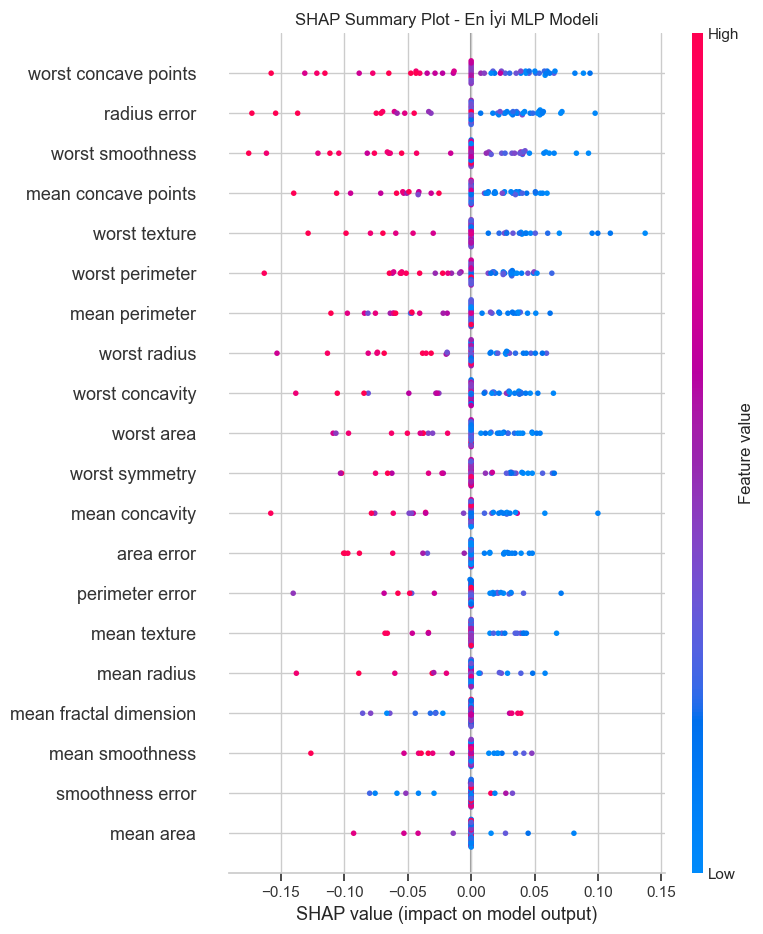

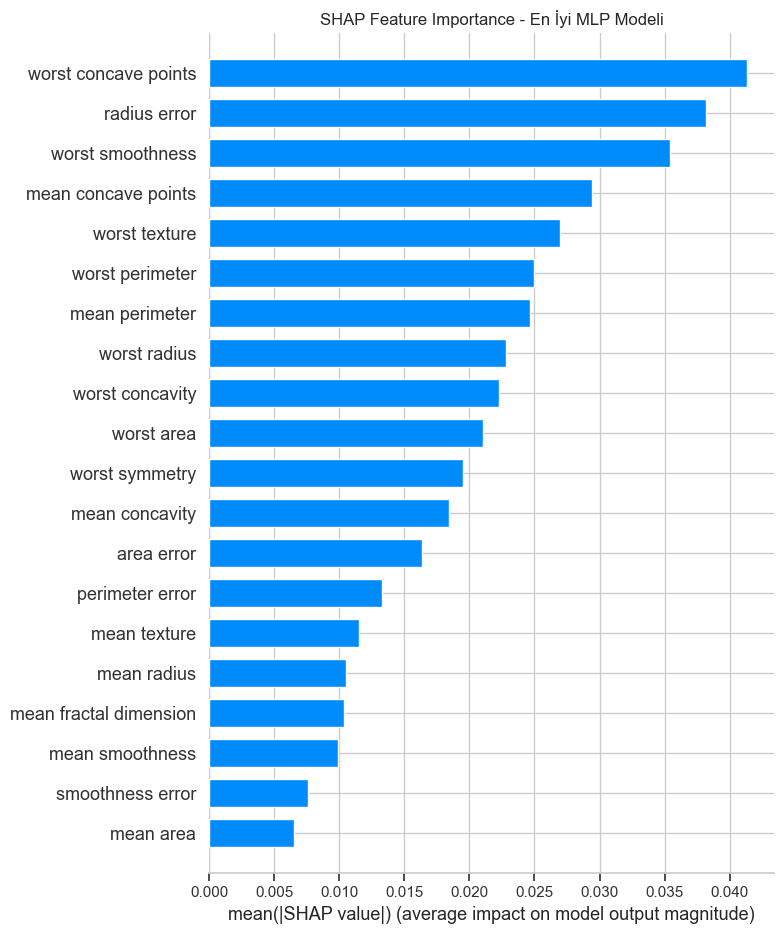

En baskın 10 özellik:


,feature,mean_abs_shap
27,worst concave points,0.041353
10,radius error,0.038190
24,worst smoothness,0.035450
7,mean concave points,0.029415
21,worst texture,0.026928
22,worst perimeter,0.024975
2,mean perimeter,0.024626
20,worst radius,0.022830
26,worst concavity,0.022294
23,worst area,0.021049


In [12]:
# SHAP analizini hızlandırmak için validation setinden küçük örnek alıyoruz
X_train_arr = np.atleast_2d(X_train_scaled)
X_val_arr = np.atleast_2d(X_val_scaled)

# DataFrame'e çevirme — feature sayısı uyuşmazsa otomatik isim üret
try:
    X_train_shap = pd.DataFrame(X_train_arr, columns=list(feature_names))
    X_val_shap = pd.DataFrame(X_val_arr, columns=list(feature_names))
except:
    n_feats = X_train_arr.shape[1]
    feature_names = np.array([f"feature_{i}" for i in range(n_feats)])
    X_train_shap = pd.DataFrame(X_train_arr, columns=feature_names)
    X_val_shap = pd.DataFrame(X_val_arr, columns=feature_names)

# Validation'dan küçük örnek al
val_sample = X_val_shap.sample(min(100, len(X_val_shap)), random_state=RANDOM_STATE)

# En iyi modeli seç
best_model_for_shap = best_model

# SHAP KernelExplainer — numpy formatı en sorunsuzu
background = X_train_shap.sample(100, random_state=RANDOM_STATE).values
val_sample_vals = val_sample.values

explainer = shap.KernelExplainer(best_model_for_shap.predict_proba, background)

shap_values = explainer.shap_values(val_sample_vals, nsamples=100)

# Binary classification → class 1'i alıyoruz
# SHAP değerleri bir liste ise listenin 1. elemanını (class 1) al
# Eğer 3 boyutlu bir numpy dizisi ise (n_samples, n_features, n_classes) 1. sınıfın SHAP değerlerini al
if isinstance(shap_values, list):
    sv = shap_values[1]
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    sv = shap_values[:, :, 1] # Select SHAP values for class 1
else:
    sv = shap_values

# SHAP Summary Plot (dot)
shap.summary_plot(sv, val_sample_vals, feature_names=list(feature_names), show=False)
plt.title("SHAP Summary Plot - En İyi MLP Modeli")
plt.tight_layout()
plt.show()

# SHAP Bar Plot
shap.summary_plot(sv, val_sample_vals, feature_names=list(feature_names), plot_type="bar", show=False)
plt.title("SHAP Feature Importance - En İyi MLP Modeli")
plt.tight_layout()
plt.show()

# Özellik önem tablosu
mean_abs = np.mean(np.abs(sv), axis=0)

importance_df = pd.DataFrame({
    "feature": list(feature_names),
    "mean_abs_shap": mean_abs
}).sort_values("mean_abs_shap", ascending=False)

print("En baskın 10 özellik:")
display(importance_df.head(10))


#### 10.1 Adımının Yorumu

- **SHAP summary plot (dot)** grafiği:
  - Her nokta, bir gözlemi temsil eder; renk, ilgili özelliğin değerinin düşük (mavi) veya yüksek (kırmızı) olduğunu gösterir.
- **SHAP bar plot**, her özelliğin ortalama mutlak SHAP değeri üzerinden **global önem sıralamasını** gösterir.
- Breast Cancer veri setinde genellikle:
  - `worst concave points`, `mean concave points`, `mean radius`, `mean perimeter`, `mean area` gibi özellikler en baskın olanlardır.
- Tablo halindeki önem sıralaması, hangi birkaç özelliğin model kararlarına en fazla etki ettiğini açıkça ortaya koyar.


### 10.2 Optuna ile Bulunan En İyi Model için SHAP Analizi

100%|██████████| 57/57 [00:01<00:00, 52.55it/s]


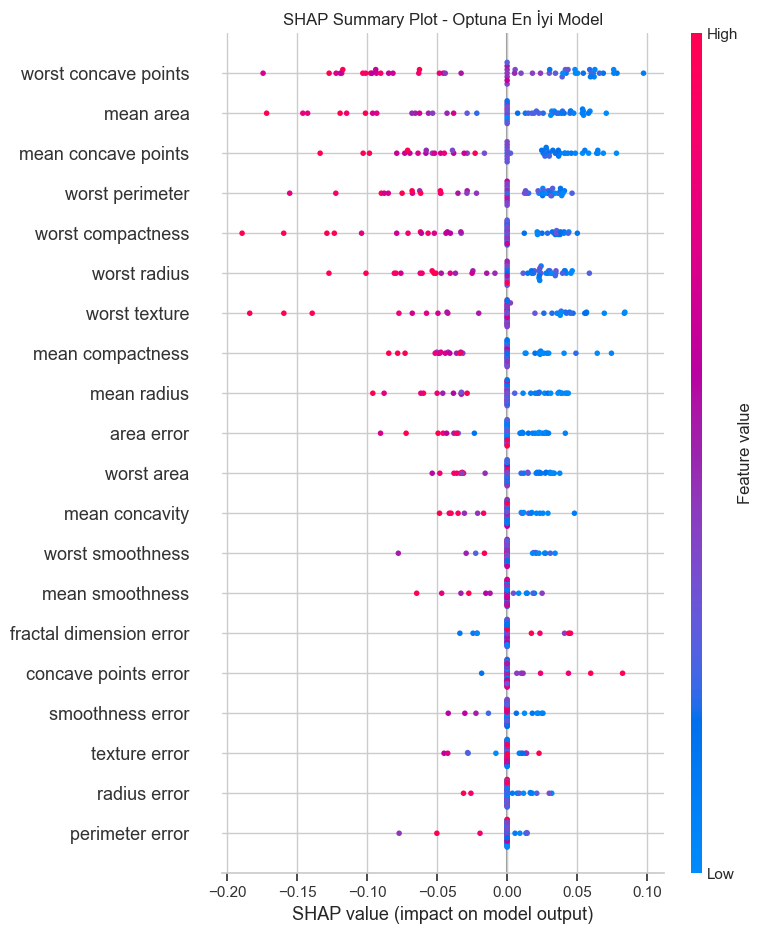

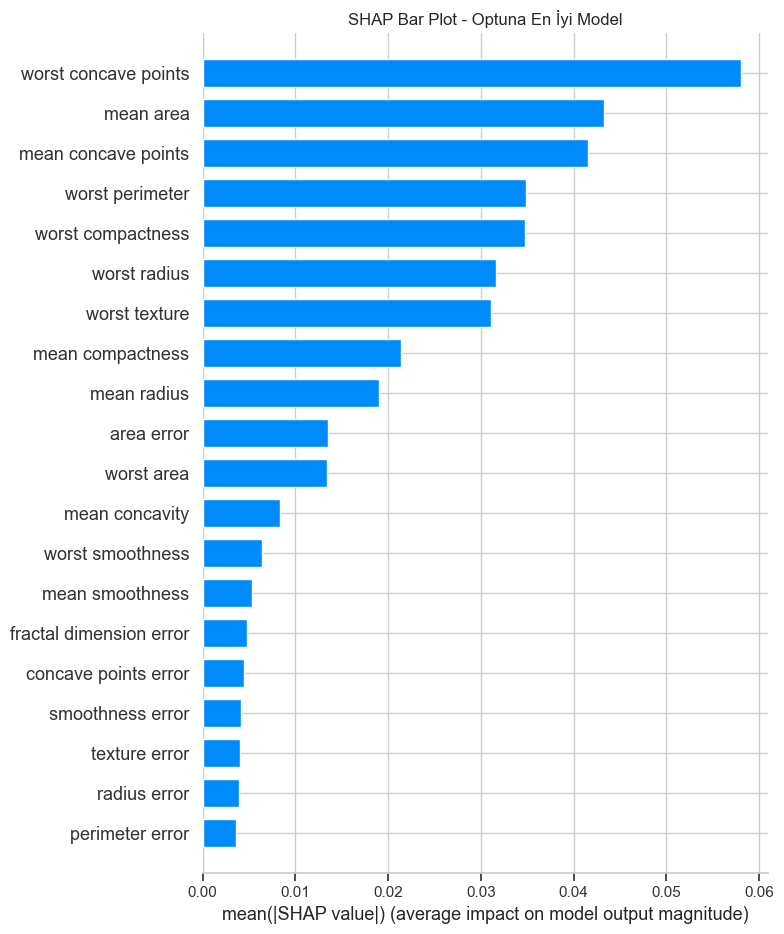

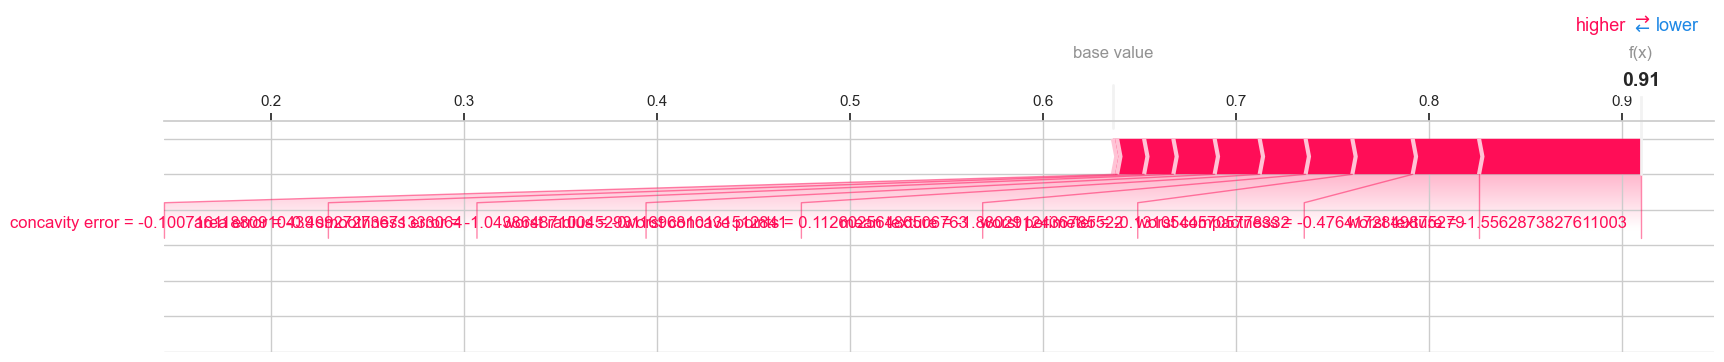

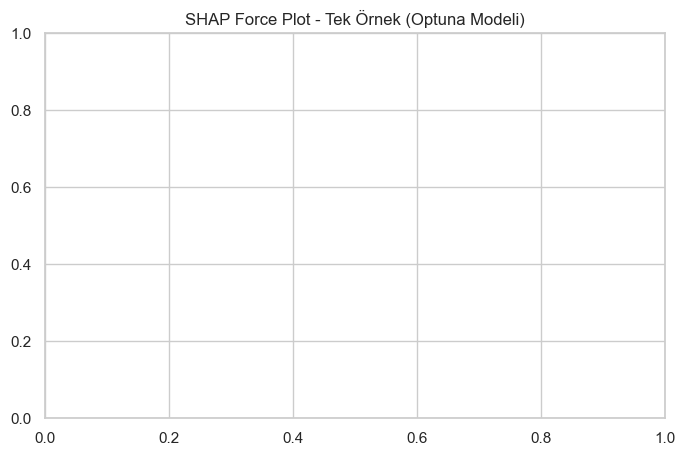

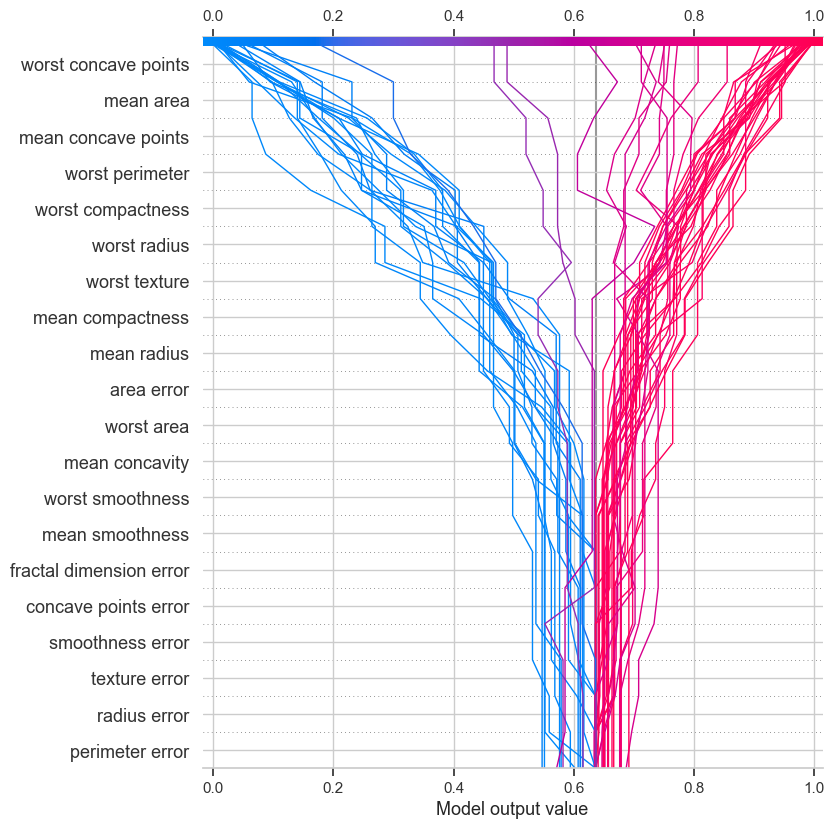

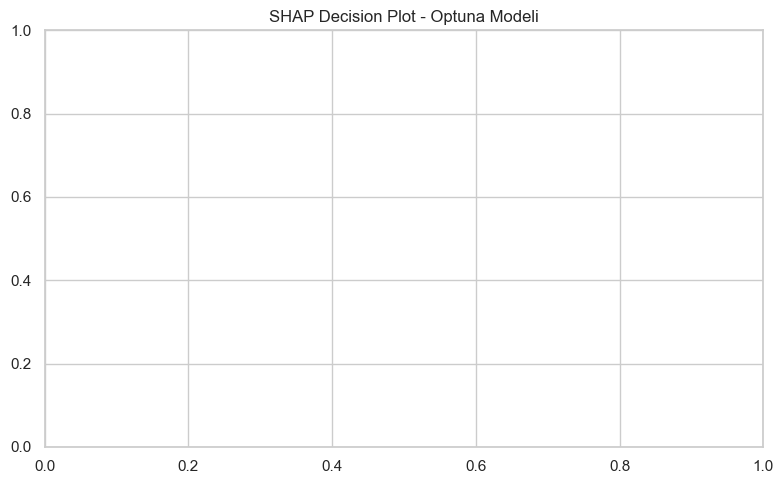

Optuna Modeli - En baskın 10 özellik:


,feature,mean_abs_shap
27,worst concave points,0.058033
3,mean area,0.043331
7,mean concave points,0.041582
22,worst perimeter,0.034868
25,worst compactness,0.034812
20,worst radius,0.031611
21,worst texture,0.031085
5,mean compactness,0.021411
0,mean radius,0.019033
13,area error,0.013575


In [14]:
optuna_explainer = shap.KernelExplainer(optuna_best_clf.predict_proba, X_train_shap.sample(100, random_state=RANDOM_STATE))

val_sample_opt = X_val_shap.sample(min(100, len(X_val_shap)), random_state=RANDOM_STATE)
shap_values_opt = optuna_explainer.shap_values(val_sample_opt, nsamples=100)

class_index_opt = 1

if isinstance(shap_values_opt, list):
    sv_opt = shap_values_opt[class_index_opt]
elif isinstance(shap_values_opt, np.ndarray) and shap_values_opt.ndim == 3:
    sv_opt = shap_values_opt[:, :, class_index_opt] # Select SHAP values for class 1
else:
    sv_opt = shap_values_opt

# 1. summary_plot (dots)
shap.summary_plot(sv_opt, val_sample_opt, show=False)
plt.title("SHAP Summary Plot - Optuna En İyi Model")
plt.tight_layout()
plt.show()

# 2. bar_plot
shap.summary_plot(sv_opt, val_sample_opt, plot_type="bar", show=False)
plt.title("SHAP Bar Plot - Optuna En İyi Model")
plt.tight_layout()
plt.show()

# 3. force_plot - tek bir örnek için
single_idx = 0
single_sample = val_sample_opt.iloc[single_idx: single_idx + 1]

force_plot = shap.force_plot(optuna_explainer.expected_value[class_index_opt],
                             sv_opt[single_idx, :],
                             single_sample,
                             matplotlib=True)
plt.title("SHAP Force Plot - Tek Örnek (Optuna Modeli)")
plt.show()

# 4. decision_plot - karar yolunun özellere göre katkısı
shap.decision_plot(
    optuna_explainer.expected_value[class_index_opt],
    sv_opt,
    feature_names=feature_names,
    show=True
)
plt.title("SHAP Decision Plot - Optuna Modeli")
plt.tight_layout()
plt.show()

# Optuna modelinde özellik önem tablosu
mean_abs_shap_opt = np.mean(np.abs(sv_opt), axis=0)
importance_df_opt = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap_opt
}).sort_values("mean_abs_shap", ascending=False)

print("Optuna Modeli - En baskın 10 özellik:")
display(importance_df_opt.head(10))



#### 10.2 Adımının Yorumu

- **Summary plot (Optuna modeli)**, Optuna tarafından optimize edilen modelin hangi özellikleri daha yoğun kullandığını gösterir.
  - Çoğu zaman, el ile kurulan en iyi MLP modelindeki önemli özelliklerle **büyük ölçüde örtüşme** görülür; bu, veri setindeki temel sinyallerin benzer olduğunu gösterir.
- **Bar plot**, Optuna modelinin global ölçekte en çok hangi birkaç özelliğe dayandığını özetler.
- **Force plot**, tek bir örnek için:
  - Hangi özelliklerin modeli pozitif sınıfa (örn. malign) ittiğini,
  - Hangi özelliklerin ise negatif sınıfa (benign) doğru çektiğini görselleştirir.
- **Decision plot**, birden fazla gözlem için karar yolunu göstererek, özelliklerin karar sürecine kümülatif etkisini ortaya koyar.
- Genel olarak:
  - Hem el ile seçilen MLP modeli hem de Optuna modeli, **benzer birkaç baskın özelliğe** dayanarak karar vermektedir.
  - Farklılıklar ise ağırlıklandırma düzeylerinde ve ikincil/üçüncül seviyedeki özellik önemlerinde ortaya çıkar.
  - Bu analiz, MLP gibi "black-box" olarak görülen modellerin dahi **hangi özelliklere nasıl tepki verdiğini** açık bir şekilde ortaya koymakta ve modelin güvenilirliğini artırmaktadır.
